# Cascaded Multi-Domain Filters for Image Denoising

CMDF uses multi-domain filter in a cascaded form by employing large and small-kernels and pixel and frequency-domain filters. 

In [1]:
import os
import sys
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import denoise_cmdf

def gray2rgb(im_rgb,img_gray):
    '''
    replace y channel with new gray image
    '''
    ycbcr = skimage.color.rgb2ycbcr(im_rgb)
    ycbcr[:,:, 0] = img_gray
    rgb = skimage.color.ycbcr2rgb(ycbcr)
    rgb[rgb<0]=0
    rgb[rgb>1]=1
    return np.uint8(rgb*255)


### Denoising with CMDF

processing time = %2.3f seconds 0.1476888656616211


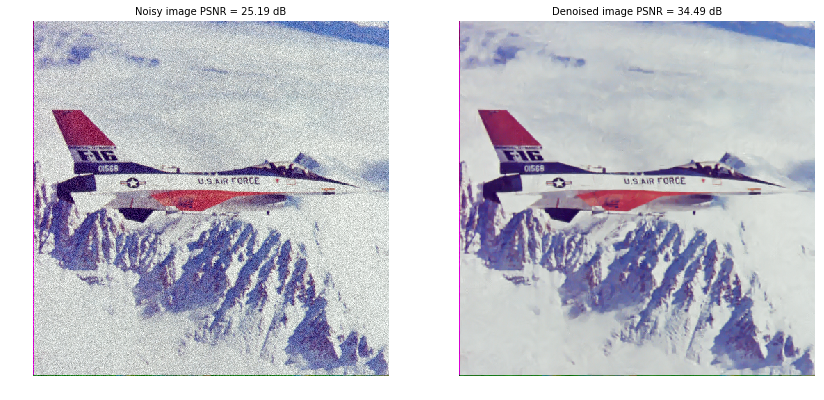

In [2]:
np.random.seed(2019)

sigma = 14

# read RGB image
image =  skimage.io.imread('../dataset/F-16.png')
# convert to grayscale
 
im_gray = skimage.color.rgb2ycbcr(image)
im_gray = np.float32(im_gray[:,:,0])

# add noise
noise = np.random.normal(0,sigma,(im_gray.shape[0],im_gray.shape[1]))
y0 = np.float32(im_gray) + np.float32(noise)

# denoise
y3, elapsed_time = denoise_cmdf.cmdfcall(y0, sigma)
mse_noisy = np.mean((y0 - np.float32(im_gray)) ** 2)
mse_denoised = np.mean((y3 - np.float32(im_gray)) ** 2)

print('processing time = %2.3f seconds',elapsed_time)

plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.title("Noisy image PSNR = %2.2f dB"%(10*np.log10(255*255/mse_noisy)), fontsize=10)
plt.axis('off')
y0[y0<0]=0
y0[y0>255]=255
#plt.imshow(denoise_cmdf.gray2rgb(image, np.uint8(y0)))
plt.imshow(gray2rgb(image,y0))

            
plt.subplot(1, 2, 2)
plt.title("Denoised image PSNR = %2.2f dB"%(10*np.log10(255*255/mse_denoised)), fontsize=10)
plt.axis('off')
#plt.imshow(denoise_cmdf.gray2rgb(image, np.uint8(y3)))
plt.imshow(gray2rgb(image,y3))
plt.show()


### Combining CMDF and BMCNN

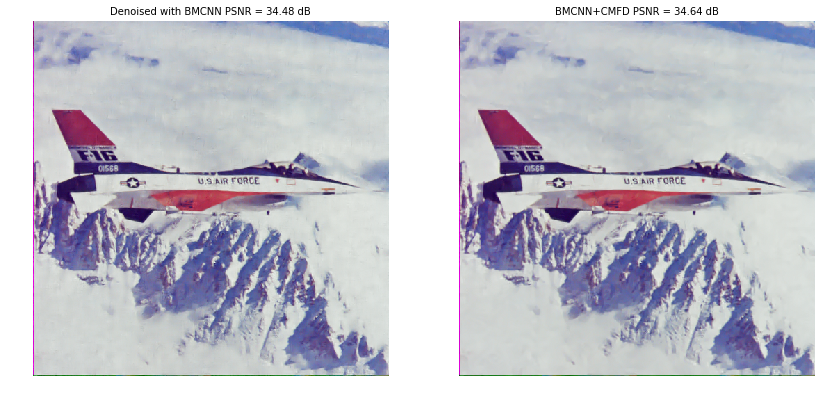

In [3]:
import bmcnn

scale_base = 15

handle = bmcnn.open('../bmcnn/models/bmcnn_16.bin')
bmcnn_out = np.zeros_like(y0)
y0p = y0*(scale_base/sigma)/255
bmcnn.predict(handle, y0p, bmcnn_out)
bmcnn_out[bmcnn_out<0.0] = 0.0
bmcnn_out[bmcnn_out>1.0] = 1.0
bmcnn_out *=(255/(scale_base/sigma)) 

mse_denoised = np.mean((bmcnn_out - np.float32(im_gray)) ** 2)
            
plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.title("Denoised with BMCNN PSNR = %2.2f dB"%(10*np.log10(255*255/mse_denoised)), fontsize=10)
plt.axis('off')
plt.imshow(gray2rgb(image,bmcnn_out))

beta = 0.65
y_m = bmcnn_out*(1-beta)+y0*beta
y_mix, elapsed_time = denoise_cmdf.cmdfcall(y_m, sigma*beta*1.075)
mse_mix = np.mean((y_mix - np.float32(im_gray)) ** 2)


plt.subplot(1, 2, 2)
plt.title("BMCNN+CMFD PSNR = %2.2f dB"%(10*np.log10(255*255/mse_mix)), fontsize=10)
plt.axis('off')
plt.imshow(gray2rgb(image,y_mix))

bmcnn.release(handle)

plt.show()
